In [470]:
reset -fs

In [511]:
# Importing the most important packages and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statistics
plt.style.use('seaborn')

In [472]:
# Importing the dataset and first exploration
df = pd.read_csv("/Users/tjadeappel/Desktop/Bootcamp/Projekt/2020-ds-Project-EDA/King_County_House_prices_dataset.csv", na_values="?")
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [473]:
# What types of data does the dataset contain
df.info()
# Why is sqft_basement of type object?
# Is date saved as a string or a datetime object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


In [474]:
type(df.date[3])
# Column date is saved as strings

str

In [475]:
# Check for missing values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
waterfront,2376,11.0
view,63,0.3
sqft_basement,454,2.1
yr_renovated,3842,17.8


0.0    19075
1.0      146
Name: waterfront, dtype: int64


<AxesSubplot:>

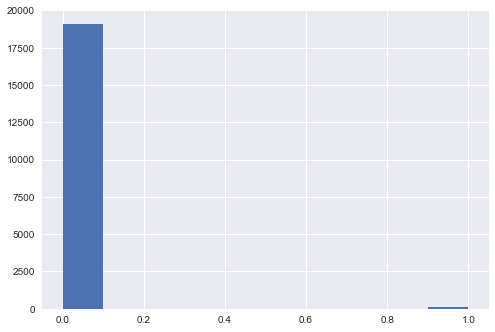

In [476]:
# What is the distribution of houses with a waterfront?
print(df.waterfront.value_counts())
df.waterfront.hist()

In [477]:
# Only very few houses have waterfronts --> assumption: houses with no value in column don't have a waterfront
# Therefore those are replaced with 0.
df.waterfront.fillna(value = 0, inplace = True)

0.0


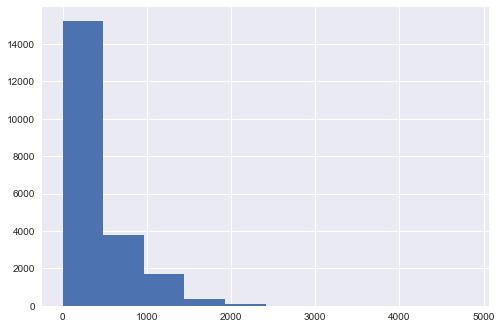

In [478]:
# What is the distribution of sqft_basement values?
df.sqft_basement.hist()
print(df.sqft_basement.median())

In [479]:
# Most houses dont seem to have a basement. Therefore the assumption is that missing values can be filled with the median 0.
df.sqft_basement.fillna(value = 0, inplace = True)

In [480]:
# Dropping rows with missing columns for view due to very small percentage of missing values
df.dropna(subset = ["view"], inplace=True)
df.shape

(21534, 21)

In [481]:
# Look at major describing statistics
df.describe().round(2)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.153400e+04,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,21534.00,17704.00,21534.00,21534.00,21534.00,21534.00,21534.00
mean,4.582351e+09,540057.66,3.37,2.12,2079.83,15090.60,1.49,0.01,0.23,3.41,7.66,1788.56,285.24,1971.00,83.77,98077.94,47.56,-122.21,1986.30,12751.08
std,2.876779e+09,366059.58,0.93,0.77,917.45,41380.21,0.54,0.08,0.77,0.65,1.17,827.75,439.33,29.38,400.24,53.51,0.14,0.14,685.12,27255.48
min,1.000102e+06,78000.00,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2.123212e+09,322000.00,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3.904945e+09,450000.00,3.00,2.25,1910.00,7617.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7.312175e+09,645000.00,4.00,2.50,2550.00,10687.75,2.00,0.00,0.00,4.00,8.00,2210.00,550.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9.900000e+09,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00


In [482]:
print(df.price.nunique())
print(df.view.unique())
print(df.condition.unique())
print(df.grade.unique())
print(df.yr_built.unique())
print(df.yr_renovated.unique())
print(df.zipcode.unique())
print(df.bedrooms.unique())
print(df.bathrooms.unique())

3613
[0. 3. 4. 2. 1.]
[3 5 4 1 2]
[ 7  6  8 11  9  5 10 12  4  3 13]
[1955 1951 1933 1965 1987 2001 1995 1960 2003 1942 1927 1977 1900 1979
 1994 1916 1921 1969 1947 1968 1985 1941 1915 1909 1948 2005 1929 1981
 1930 1904 1996 2000 1984 2014 1922 1959 1966 1953 1950 2008 1991 1954
 1973 1925 1989 1972 1986 1956 2002 1992 1964 1952 1961 2006 1988 1962
 1939 1946 1967 1975 1980 1910 1983 1978 1905 1971 2010 1945 1924 1990
 1914 1926 1923 2007 1976 1949 1999 1901 1993 1920 1997 1943 1957 2004
 1940 1918 1928 1974 1911 1936 1937 1982 1908 1931 1963 1998 1913 2013
 1907 1958 2012 1912 2011 1932 1944 1902 2009 1903 1970 2015 1934 1938
 1919 1917 1906 1935]
[   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 2001. 1980. 1971.
 1979. 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963.
 1951. 1962. 1953. 1993. 1996. 1955. 1982. 1956. 

In [483]:
# The column id will  probably not have much information, which is why it will be dropped
df.drop("id", axis = 1, inplace = True)

In [484]:
# The column date will be converted to datetime objects and reduced to the month to make it useful for the regression model
df.date = pd.to_datetime(df.date, format= "%m/%d/%Y")
df['month'] = pd.DatetimeIndex(df['date']).month
df.drop("date", axis = 1, inplace = True)

In [485]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null float64
yr_built         21534 non-null int64
yr_renovated     17704 non-null float64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
month            21534 non-null int64
dtypes: float64(9), int64(11)
memory usage: 3.5 MB


In [486]:
# Coordinates lat and long will be dropped and zipcode will probably the reference for location (categorical --> dummies)
df.drop(["lat","long"], axis = 1, inplace = True)

# Yr_built and yr_renovated can probably merged into a new feature (yr_lastchange) and the respective columns dropped
df["yr_lastchange"] = df[["yr_built", "yr_renovated"]].max(axis=1)
df.drop(["yr_built", "yr_renovated"], axis = 1, inplace = True)

In [487]:
# Converting categorical variables to Strings
df[["waterfront","condition","grade","zipcode","month"]] = \
df[["waterfront","condition","grade","zipcode","month"]].astype(str)

In [488]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 17 columns):
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null object
view             21534 non-null float64
condition        21534 non-null object
grade            21534 non-null object
sqft_above       21534 non-null int64
sqft_basement    21534 non-null float64
zipcode          21534 non-null object
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
month            21534 non-null object
yr_lastchange    21534 non-null float64
dtypes: float64(6), int64(6), object(5)
memory usage: 3.0+ MB


In [489]:
# Dividing into continuous and categorical variables.
continuous_var = list(df.select_dtypes(
                        ['int64','float64','bool']).columns.values)
categorical_var=list(df.select_dtypes(
                        ['object']).columns.values)
categorical_var

['waterfront', 'condition', 'grade', 'zipcode', 'month']

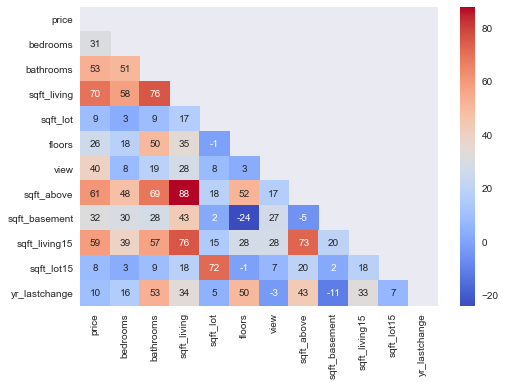

In [490]:
# Creating Heatmap for correlation coefficients of continuous variables
X_dum=pd.get_dummies(df[continuous_var].copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')

In [491]:
# Checking R-squared for single continuous variables
print('R squared for each possible continuous explanatory variable:' )
for explanatory_var in continuous_var:
    model = 'price ~ {:}'.format(explanatory_var)
    rs = smf.ols(formula=model, data=df).fit().rsquared
    print('{:7s} \t \t= {:.3}'.format(explanatory_var, rs))

R squared for each possible continuous explanatory variable:
price   	 	= 1.0
bedrooms 	 	= 0.0949
bathrooms 	 	= 0.276
sqft_living 	 	= 0.492
sqft_lot 	 	= 0.00816
floors  	 	= 0.0661
view    	 	= 0.157
sqft_above 	 	= 0.367
sqft_basement 	 	= 0.102
sqft_living15 	 	= 0.343
sqft_lot15 	 	= 0.00692
yr_lastchange 	 	= 0.00957


In [492]:
# Sqft_living, sqft_above, sqft_living15, bathrooms and view might be interesting features to consider
# They seem to have a good positive linear correlation with the sale price and the highest single R-squared values
# But sqft_living is also highly correlated with sqft_above, sqft_living15 and bathrooms
# Those columns might not give much additional information. Sqft_basement should maybe be added to a possible model.

In [493]:
categorical_var

['waterfront', 'condition', 'grade', 'zipcode', 'month']

/Users/tjadeappel/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1551.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:13:32   Log-Likelihood:            -3.0567e+05
No. Observations:               21534   AIC:                         6.113e+05
Df Residuals:                   21532   BIC:                         6.114e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.322e+05   2417.475    220.166      0.000    5.28e+05    5.37e+05
waterfront_1.0   1.16e+06   2.95e+04     39.384      0.000     1.1e+06    1.22e+06
==============================================================================
Omnibus:                    17639.239   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           905012.358
Skew:                           3.596   Prob(JB):                         0.00
Kurtosis:                      33.934   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

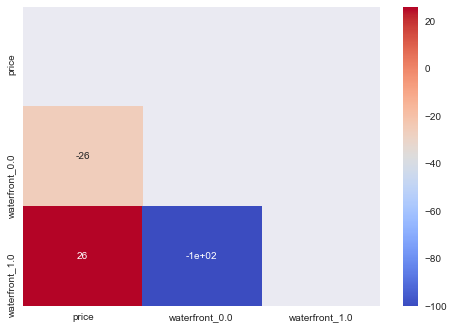

In [494]:
# Check correlation and R-Squared for waterfront in relation to price

X_dum_waterfront=pd.get_dummies(df[["waterfront","price"]].copy())
mask_waterfront = np.triu(X_dum_waterfront.corr())
ax_waterfront = sns.heatmap(round(X_dum_waterfront.corr()*100,0)
                 ,annot=True
                 ,mask=mask_waterfront
                 ,cmap='coolwarm')

X_dum_waterfront=pd.get_dummies(df[["waterfront","price"]].copy(), drop_first = True)

X_waterfront = X_dum_waterfront.drop("price", axis=1)
X_waterfront = sms.add_constant(X_waterfront)
y_waterfront = X_dum_waterfront["price"]
model_waterfront = sms.OLS(y_waterfront, X_waterfront)
results_waterfront = model_waterfront.fit()
results_waterfront.summary()

# R-squared: 0.067

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     37.31
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           3.78e-31
Time:                        18:13:34   Log-Likelihood:            -3.0634e+05
No. Observations:               21534   AIC:                         6.127e+05
Df Residuals:                   21529   BIC:                         6.127e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.411e+05   6.77e+04      5.034      0.000    2.08e+05    4.74e+05
condition_2 -1.289e+04   7.33e+04     -0.176      0.860   -1.57e+05    1.31e+05
condition_3  2.012e+05   6.78e+04      2.966      0.003    6.82e+04    3.34e+05
condition_4  1.794e+05   6.79e+04      2.641      0.008    4.62e+04    3.12e+05
condition_5  2.712e+05   6.83e+04      3.969      0.000    1.37e+05    4.05e+05
==============================================================================
Omnibus:                    18951.403   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1112098.473
Skew:                           3.993   Prob(JB):                         0.00
Kurtosis:                      37.288   Cond. No.                         75.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

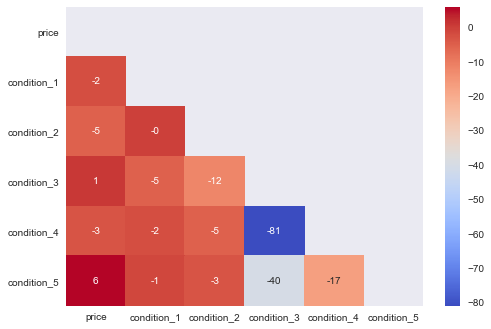

In [495]:
# Check correlation and R-Squared for condition in relation to price

X_dum_condition=pd.get_dummies(df[["condition","price"]].copy())
mask_condition = np.triu(X_dum_condition.corr())
ax_condition = sns.heatmap(round(X_dum_condition.corr()*100,0)
                 ,annot=True
                 ,mask=mask_condition
                 ,cmap='coolwarm')

X_dum_condition=pd.get_dummies(df[["condition","price"]].copy(), drop_first = True)

X_condition = X_dum_condition.drop("price", axis=1)
X_condition = sms.add_constant(X_condition)
y_condition = X_dum_condition["price"]
model_condition = sms.OLS(y_condition, X_condition)
results_condition = model_condition.fit()
results_condition.summary()

# R-squared: 0.007

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     2324.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:13:37   Log-Likelihood:            -2.9853e+05
No. Observations:               21534   AIC:                         5.971e+05
Df Residuals:                   21523   BIC:                         5.972e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.072e+06   7552.781    141.962      0.000    1.06e+06    1.09e+06
grade_11    4.247e+05   1.48e+04     28.674      0.000    3.96e+05    4.54e+05
grade_12    1.095e+06   2.81e+04     38.974      0.000    1.04e+06    1.15e+06
grade_13    2.639e+06   7.08e+04     37.257      0.000     2.5e+06    2.78e+06
grade_3    -8.102e+05   2.54e+05     -3.190      0.001   -1.31e+06   -3.12e+05
grade_4    -8.602e+05   4.94e+04    -17.399      0.000   -9.57e+05   -7.63e+05
grade_5    -8.237e+05    1.8e+04    -45.802      0.000   -8.59e+05   -7.88e+05
grade_6    -7.703e+05   9422.457    -81.753      0.000   -7.89e+05   -7.52e+05
grade_7    -6.696e+05   8015.508    -83.544      0.000   -6.85e+05   -6.54e+05
grade_8    -5.291e+05   8227.625    -64.313      0.000   -5.45e+05   -5.13e+05
grade_9    -2.979e+05   9044.270    -32.943      0.000   -3.16e+05    -2.8e+05
==============================================================================
Omnibus:                    15613.822   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           768727.663
Skew:                           2.969   Prob(JB):                         0.00
Kurtosis:                      31.662   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

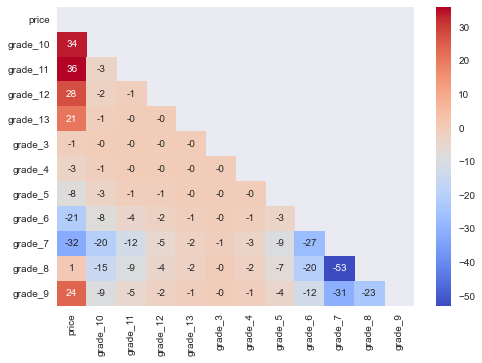

In [496]:
# Check correlation and R-Squared for grade in relation to price

X_dum_grade=pd.get_dummies(df[["grade","price"]].copy())
mask_grade = np.triu(X_dum_grade.corr())
ax_grade = sns.heatmap(round(X_dum_grade.corr()*100,0)
                 ,annot=True
                 ,mask=mask_grade
                 ,cmap='coolwarm')

X_dum_grade=pd.get_dummies(df[["grade","price"]].copy(), drop_first = True)

X_grade = X_dum_grade.drop("price", axis=1)
X_grade = sms.add_constant(X_grade)
y_grade = X_dum_grade["price"]
model_grade = sms.OLS(y_grade, X_grade)
results_grade = model_grade.fit()
results_grade.summary()

# R-squared: 0.519

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.876
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           0.000878
Time:                        18:13:41   Log-Likelihood:            -3.0640e+05
No. Observations:               21534   AIC:                         6.128e+05
Df Residuals:                   21522   BIC:                         6.129e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.26e+05   1.17e+04     44.822      0.000    5.03e+05    5.49e+05
month_10    1.329e+04   1.45e+04      0.919      0.358   -1.51e+04    4.16e+04
month_11   -3745.8141   1.53e+04     -0.245      0.806   -3.37e+04    2.62e+04
month_12   -1271.8300   1.51e+04     -0.084      0.933   -3.09e+04    2.84e+04
month_2    -1.675e+04   1.57e+04     -1.069      0.285   -4.75e+04     1.4e+04
month_3     1.829e+04   1.45e+04      1.264      0.206   -1.01e+04    4.67e+04
month_4     3.449e+04   1.41e+04      2.450      0.014    6900.857    6.21e+04
month_5     2.405e+04   1.39e+04      1.730      0.084   -3199.309    5.13e+04
month_6     3.089e+04   1.41e+04      2.188      0.029    3221.591    5.86e+04
month_7     1.903e+04   1.41e+04      1.351      0.177   -8573.835    4.66e+04
month_8     1.063e+04   1.44e+04      0.739      0.460   -1.76e+04    3.88e+04
month_9     3992.5067   1.46e+04      0.273      0.785   -2.47e+04    3.26e+04
==============================================================================
Omnibus:                    18890.789   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1088435.293
Skew:                           3.979   Prob(JB):                         0.00
Kurtosis:                      36.908   Cond. No.                         17.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

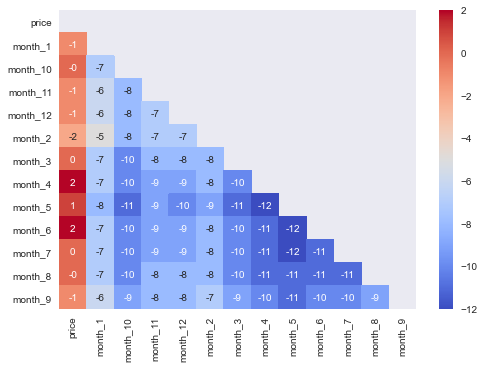

In [497]:
# Check correlation and R-Squared for month in relation to price

X_dum_month=pd.get_dummies(df[["month","price"]].copy())
mask_month = np.triu(X_dum_month.corr())
ax_month = sns.heatmap(round(X_dum_month.corr()*100,0)
                 ,annot=True
                 ,mask=mask_month
                 ,cmap='coolwarm')

X_dum_month=pd.get_dummies(df[["month","price"]].copy(), drop_first = True)

X_month = X_dum_month.drop("price", axis=1)
X_month = sms.add_constant(X_month)
y_month = X_dum_month["price"]
model_month = sms.OLS(y_month, X_month)
results_month = model_month.fit()
results_month.summary()

# R-squared: 0.001

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     215.1
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:13:47   Log-Likelihood:            -3.0076e+05
No. Observations:               21534   AIC:                         6.017e+05
Df Residuals:                   21464   BIC:                         6.022e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.809e+05   1.49e+04     18.878      0.000    2.52e+05     3.1e+05
zipcode_98002  -4.66e+04   2.49e+04     -1.870      0.061   -9.54e+04    2236.629
zipcode_98003  1.323e+04   2.25e+04      0.589      0.556   -3.08e+04    5.73e+04
zipcode_98004  1.078e+06   2.17e+04     49.557      0.000    1.04e+06    1.12e+06
zipcode_98005  5.294e+05   2.64e+04     20.090      0.000    4.78e+05    5.81e+05
zipcode_98006  5.793e+05   1.95e+04     29.666      0.000    5.41e+05    6.18e+05
zipcode_98007  3.364e+05    2.8e+04     12.006      0.000    2.81e+05    3.91e+05
zipcode_98008  3.647e+05   2.24e+04     16.276      0.000    3.21e+05    4.09e+05
zipcode_98010  1.428e+05   3.19e+04      4.479      0.000    8.03e+04    2.05e+05
zipcode_98011  2.088e+05   2.51e+04      8.312      0.000     1.6e+05    2.58e+05
zipcode_98014  1.747e+05   2.94e+04      5.951      0.000    1.17e+05    2.32e+05
zipcode_98019  1.439e+05   2.53e+04      5.691      0.000    9.44e+04    1.94e+05
zipcode_98022  3.606e+04   2.37e+04      1.519      0.129   -1.05e+04    8.26e+04
zipcode_98023  5130.2482   1.95e+04      0.263      0.793   -3.32e+04    4.34e+04
zipcode_98024  3.082e+05    3.5e+04      8.798      0.000     2.4e+05    3.77e+05
zipcode_98027  3.349e+05   2.04e+04     16.426      0.000    2.95e+05    3.75e+05
zipcode_98028  1.819e+05   2.24e+04      8.108      0.000    1.38e+05    2.26e+05
zipcode_98029  3.318e+05   2.17e+04     15.320      0.000    2.89e+05    3.74e+05
zipcode_98030  1.531e+04   2.31e+04      0.664      0.507   -2.99e+04    6.05e+04
zipcode_98031  1.946e+04   2.26e+04      0.860      0.390   -2.49e+04    6.38e+04
zipcode_98032 -2.986e+04   2.94e+04     -1.017      0.309   -8.74e+04    2.77e+04
zipcode_98033  5.231e+05   2.01e+04     25.983      0.000    4.84e+05    5.63e+05
zipcode_98034  2.409e+05   1.92e+04     12.570      0.000    2.03e+05    2.78e+05
zipcode_98038  8.613e+04   1.89e+04      4.559      0.000    4.91e+04    1.23e+05
zipcode_98039   1.88e+06   4.26e+04     44.190      0.000     1.8e+06    1.96e+06
zipcode_98040  9.023e+05   2.25e+04     40.106      0.000    8.58e+05    9.46e+05
zipcode_98042  3.079e+04   1.92e+04      1.607      0.108   -6773.476    6.83e+04
zipcode_98045  1.594e+05   2.41e+04      6.602      0.000    1.12e+05    2.07e+05
zipcode_98052  3.643e+05    1.9e+04     19.198      0.000    3.27e+05    4.01e+05
zipcode_98053  3.968e+05   2.05e+04     19.382      0.000    3.57e+05    4.37e+05
zipcode_98055  2.338e+04   2.28e+04      1.027      0.304   -2.12e+04     6.8e+04
zipcode_98056  1.389e+05   2.05e+04      6.791      0.000    9.88e+04    1.79e+05
zipcode_98058   7.32e+04   1.99e+04      3.676      0.000    3.42e+04    1.12e+05
zipcode_98059  2.127e+05   1.98e+04     10.756      0.000    1.74e+05    2.52e+05
zipcode_98065  2.491e+05   2.19e+04     11.366   

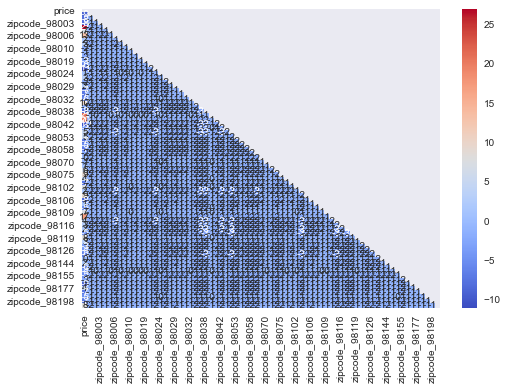

In [498]:
# Check correlation and R-Squared for zipcode in relation to price

X_dum_zipcode=pd.get_dummies(df[["zipcode","price"]].copy())
mask_zipcode = np.triu(X_dum_zipcode.corr())
ax_zipcode = sns.heatmap(round(X_dum_zipcode.corr()*100,0)
                 ,annot=True
                 ,mask=mask_zipcode
                 ,cmap='coolwarm')

X_dum_zipcode=pd.get_dummies(df[["zipcode","price"]].copy(), drop_first = True)

X_zipcode = X_dum_zipcode.drop("price", axis=1)
X_zipcode = sms.add_constant(X_zipcode)
y_zipcode = X_dum_zipcode["price"]
model_zipcode = sms.OLS(y_zipcode, X_zipcode)
results_zipcode = model_zipcode.fit()
results_zipcode.summary()

# R-squared: 0.409

In [499]:
# Erster Schuss für Regressionsmodell:
# Einfließende Features: grade, zip code, sqft_living, sqft_above, sqft_living15, bathrooms, view and sqft_basement

X_modell1 = pd.concat([X_dum_zipcode.drop("price", axis=1), X_dum_grade.drop("price", axis=1),
                      df[["sqft_living", "sqft_above", "sqft_living15", "bathrooms", "view",
                         "sqft_basement"]]], axis=1)
X_modell1 = sms.add_constant(X_modell1)
y_modell1 = df["price"]
model_modell1 = sms.OLS(y_modell1, X_modell1)
results_modell1 = model_modell1.fit()
results_modell1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1072.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:13:57   Log-Likelihood:            -2.8857e+05
No. Observations:               21534   AIC:                         5.773e+05
Df Residuals:                   21448   BIC:                         5.780e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.331e+05   1.36e+04      9.764      0.000    1.06e+05     1.6e+05
zipcode_98002  1.625e+04   1.42e+04      1.145      0.252   -1.16e+04    4.41e+04
zipcode_98003 -4347.3269   1.28e+04     -0.340      0.734   -2.94e+04    2.07e+04
zipcode_98004  7.832e+05   1.25e+04     62.625      0.000    7.59e+05    8.08e+05
zipcode_98005  3.347e+05   1.51e+04     22.181      0.000    3.05e+05    3.64e+05
zipcode_98006  2.572e+05   1.13e+04     22.730      0.000    2.35e+05    2.79e+05
zipcode_98007  2.687e+05   1.59e+04     16.851      0.000    2.37e+05       3e+05
zipcode_98008  2.876e+05   1.28e+04     22.535      0.000    2.63e+05    3.13e+05
zipcode_98010  7.601e+04   1.81e+04      4.193      0.000    4.05e+04    1.12e+05
zipcode_98011  1.397e+05   1.43e+04      9.767      0.000    1.12e+05    1.68e+05
zipcode_98014  1.012e+05   1.67e+04      6.053      0.000    6.84e+04    1.34e+05
zipcode_98019  9.483e+04   1.44e+04      6.591      0.000    6.66e+04    1.23e+05
zipcode_98022 -1340.0185   1.35e+04     -0.099      0.921   -2.79e+04    2.52e+04
zipcode_98023 -1.985e+04   1.11e+04     -1.784      0.074   -4.16e+04    1953.769
zipcode_98024  1.728e+05   1.99e+04      8.669      0.000    1.34e+05    2.12e+05
zipcode_98027   1.76e+05   1.17e+04     15.093      0.000    1.53e+05    1.99e+05
zipcode_98028  1.367e+05   1.28e+04     10.706      0.000    1.12e+05    1.62e+05
zipcode_98029  2.211e+05   1.24e+04     17.821      0.000    1.97e+05    2.45e+05
zipcode_98030  7949.3301   1.31e+04      0.607      0.544   -1.77e+04    3.36e+04
zipcode_98031  2.437e+04   1.29e+04      1.893      0.058    -861.581    4.96e+04
zipcode_98032   1.13e+04   1.67e+04      0.677      0.499   -2.14e+04     4.4e+04
zipcode_98033   3.72e+05   1.15e+04     32.400      0.000    3.49e+05    3.94e+05
zipcode_98034  2.093e+05   1.09e+04     19.202      0.000    1.88e+05    2.31e+05
zipcode_98038  3.627e+04   1.08e+04      3.368      0.001    1.52e+04    5.74e+04
zipcode_98039  1.267e+06   2.44e+04     51.855      0.000    1.22e+06    1.31e+06
zipcode_98040  5.345e+05    1.3e+04     41.095      0.000    5.09e+05     5.6e+05
zipcode_98042  1.613e+04   1.09e+04      1.481      0.139   -5222.386    3.75e+04
zipcode_98045  9.447e+04   1.37e+04      6.886      0.000    6.76e+04    1.21e+05
zipcode_98052  2.515e+05   1.09e+04     23.159      0.000     2.3e+05    2.73e+05
zipcode_98053  2.162e+05   1.17e+04     18.431      0.000    1.93e+05    2.39e+05
zipcode_98055   4.46e+04   1.29e+04      3.448      0.001    1.92e+04    6.99e+04
zipcode_98056  1.034e+05   1.16e+04      8.883      0.000    8.06e+04    1.26e+05
zipcode_98058  4.565e+04   1.13e+04      4.031      0.000    2.35e+04    6.78e+04
zipcode_98059  8.748e+04   1.13e+04      7.741      0.000    6.53e+04     1.1e+05
zipcode_98065  7.942e+04   1.26e+04      6.328   

In [500]:
X_modell1.shape

(21534, 86)

In [501]:
y_modell1.shape

(21534,)

In [512]:
# Test des Modells mit RepeatedKfold Cross-Validation

MSE = []
rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=42)
#X_modell1 = X_modell1.values
#y_modell1 = y_modell1.values
for train_index, test_index in rkf.split(X_modell1):
    X_train, X_test = X_modell1[train_index,:], X_modell1[test_index,:]
    y_train, y_test = y_modell1[train_index], y_modell1[test_index]
    
    X_train = sms.add_constant(X_train)
    
    model_Rkfold = sms.OLS(y_train, X_train)
    results_Rkfold = model_Rkfold.fit()
    
    #results_modell1.summary()
    y_true = y_test
    y_pred = results_Rkfold.predict(X_test)
    MSE.append(mean_squared_error(y_true, y_pred))
    
print("The MSE for the model with the chosen parameters is on average: "\
      + str (round(sum(MSE) / len(MSE),2))+"$")
print("The MSE for the model with the chosen parameters has a median of: "\
      + str (round(statistics.median(MSE),2))+"$")

The MSE for the model with the chosen parameters is on average: 26144428577.27$
The MSE for the model with the chosen parameters has a median of: 25975338681.03$


In [514]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import numpy as np

scores = cross_val_score(LinearRegression(), X_modell1, y_modell1, cv = RepeatedKFold(n_splits = 5, n_repeats = 100))
print(np.mean(scores))
print(np.median(scores))

0.8051642078877242
0.8059022863620309
